This notebook provides examples of how to call the hyperconvo functions from Convokit and perform analyses similar to the ones presented in the corresponding paper (http://www.cs.cornell.edu/~cristian/Patterns_of_participant_interactions.html), which describes the hypergraph methodology for modeling and analyzing online public discussions.

Note that due to limitations in what data we can access and distribute, the beta version of the hypergraph methodology presented here currently supports less functionality:

* Instead of Facebook data, we release a dataset of discussions from Reddit (the 1000 most recent threads, with at least 10 comments, from 100 highly active subreddits -- more details in the corresponding readme here: https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/tree/master/datasets/reddit-corpus). For demonstration purposes, we here use a small subset of this dataset ("reddit-corpus-small") containing 100 threads per subreddit.
* Since Reddit does not provide information on who reacted to (i.e., upvoted) each comment, we are presently unable to support reaction-edges in the hypergraph. As such, we can only compute features over in/outdegree distributions of _reply_-edges, and the feature set derived from motifs in the hypergraph is limited to counts and binary indicators or whether or not a motif is present. We will work  towards supporting reactions as well.

In [1]:
import os
os.getcwd()
os.chdir("..")
os.chdir("..")
os.getcwd()

'/Users/macuser/Desktop/hyperconv-refactor/Cornell-Conversational-Analysis-Toolkit'

In [2]:
import convokit

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

First we download the reddit corpus:

In [4]:
filename = os.path.join(os.getcwd(), "examples/hyperconvo/reddit-corpus-small/")

corpus = convokit.Corpus(filename=filename)

In [52]:
a = set([utt.id for utt in corpus.iter_utterances()])

In [53]:
len(a)

282418

In [51]:
len(list(corpus.iter_utterances()))

282418

In [49]:
len(list(corpus.iter_users()))

115431

In [48]:
len(list(corpus.iter_conversations()))

8285

In [40]:
a = set([utt.name for utt in corpus.iter_users()])

In [41]:
len(a)

115431

In [6]:
# corpus = convokit.Corpus(filename=convokit.download("reddit-corpus"))

We will compute features over only the first 10 comments that occur in a thread, for  threads which are at least 10 comments long (controling for thread length in this way). Notice that we set include_root to False as we are interested in comment threads, i.e. threads that begin from a top-level comment, not from the post itself.

In [7]:
threads = corpus.utterance_threads(prefix_len=10, include_root=False)

In [8]:
def display_thread_helper(thread, root, indent=0):
    print(" "*indent + thread[root].user.name)
    children = [k for k, v in thread.items() if v.reply_to == root]
    for child in children:
        display_thread_helper(thread, child, indent=indent+4)
def display_thread(root):
    return display_thread_helper(threads[root],root)

The following are threads that come from the /r/canada subreddit. 

In [9]:
len(threads)

10000

In [10]:
demo_threads = [
    # https://www.reddit.com/r/cringepics/comments/9c4wc2/mr_hands_over_here_on_a_nationally_televised/e582bti/
                'e582bti', 
    # https://www.reddit.com/r/askscience/comments/9c25cz/how_many_average_modern_nuclear_weapons_1mt_would/e57sosp/
                'e57sosp',
    # https://www.reddit.com/r/movies/comments/9is5ew/sony_has_officially_retitled_the_girl_with_the/e6lzwfg/
                'e6lzwfg'
               ]

We print the structure of the thread: the reply-structure (where subsequent replies in the comment tree are indented), and the authors of each comment. There are some high-level qualitative differences that you might immediately see; our goal is to automatically extract a superset of these intuitive distinctions. For instance, we notice that thread t1_c32bcq8 has a very linear structure, while t1_c322oa7 is flatter; to capture this difference, we might compute statistics on the distribution of in-degrees of nodes in the reply tree. We also intuit that some conversations involve a few people replying repeatedly to each other, whereas others may involve users stopping by to chime in once and then leaving; we'll later codify this difference via statistics on the indegrees and outdegrees of hypernodes (users).

In [11]:
for thread in demo_threads:
    print(thread)
    print('---')
    display_thread(thread)
    print()

e582bti
---
Greasier
    myusernamebarelyfits
        BonusEruptus
            [deleted]
    Nouia
    perforatedcolon
    EXTRAVAGANT_COMMENT
        Jaybeux
            balla786
    [deleted]

e57sosp
---
B-Knight
    JackhusChanhus
        mahajohn1975
            JackhusChanhus
                [deleted]
                [deleted]
                    mahajohn1975
                        [deleted]
                dongasaurus
                    [deleted]

e6lzwfg
---
MikeArrow
    StudBoi69
        la2nd2014
            blorpblorpbloop
        Jas378
            kitx07
    Peanlocket
        duhhhhdoy
            Luxx815
    SucculentsandSuch



One technical note: Since we don't have access to the author of deleted comments, we make the assumption for now that each deleted comment in a particular thread was written by the same author -- a potential source of noise in the subsequent analyses.

The above method is called by fit_transform(), but we call the utterance_threads() method directly so we can visualize the thread. Typically, to extract hypergraph features, we would simply:

In [12]:
# create a hyperconvo object and use it to extract features
hc = convokit.HyperConvo(prefix_len=10, min_thread_len=10, include_root=False)
hc.fit_transform(corpus)

threads_feats = corpus.get_meta()["hyperconvo"]

In [13]:
def clean_value(x):
    if np.isinf(x) or np.isnan(x):
        return -1
    return x

In [14]:
feat_names = list(next(iter(threads_feats.values())).keys())

In [15]:
feat_names[:10]

['max[outdegree over c->c responses]',
 'max[indegree over c->c responses]',
 'argmax[outdegree over c->c responses]',
 'argmax[indegree over c->c responses]',
 'norm.max[outdegree over c->c responses]',
 'norm.max[indegree over c->c responses]',
 '2nd-largest[outdegree over c->c responses]',
 '2nd-largest[indegree over c->c responses]',
 '2nd-argmax[outdegree over c->c responses]',
 '2nd-argmax[indegree over c->c responses]']

In [16]:
thread_ids = []
feats = []
for key, feat_dict in threads_feats.items():
    thread_ids.append(key)
    feats.append([clean_value(feat_dict[k]) for k in feat_names])

For later convenience we will store feature values in a dataframe:

In [17]:
feat_df = pd.DataFrame(data=feats, index=thread_ids, columns=feat_names)

Here are some examples of features computed over the three example threads from before:

In [18]:
C_C_indegree_feats = [x for x in feat_names if 'indegree over C->C responses' in x]
C_C_mid_outdegree_feats = [x for x in feat_names if 'outdegree over C->C mid-thread responses' in x]
motif_count_feats = [x for x in feat_names if ('count' in x) and ('mid' not in x)]

Features derived from the distribution of hypernode to hypernode indegrees (i.e., "how many other people are responding to a particular discussion participant?"). As in the paper, we compute various summary statistics over the distribution. 

As noted at the start of this notebook, since we do not have access to reaction information, these distributions encompass only the reply structure within the thread.

In [19]:
feat_df.loc[demo_threads][C_C_indegree_feats].T.sort_index()

,e582bti,e57sosp,e6lzwfg
2nd-argmax[indegree over C->C responses],1.000000,2.000000,1.000000
2nd-largest / max[indegree over C->C responses],0.200000,0.500000,0.666667
2nd-largest[indegree over C->C responses],1.000000,2.000000,2.000000
argmax[indegree over C->C responses],0.000000,1.000000,0.000000
entropy[indegree over C->C responses],1.303092,1.427061,1.676988
max[indegree over C->C responses],5.000000,4.000000,3.000000
mean-nonzero[indegree over C->C responses],1.800000,1.800000,1.500000
mean[indegree over C->C responses],1.000000,1.800000,0.900000
norm.2nd-largest[indegree over C->C responses],0.111111,0.222222,0.222222
norm.max[indegree over C->C responses],0.555556,0.444444,0.333333


Features derived from the distribution of hypernode to hypernode outdegrees in the _middle_ of the thread (i.e., "beyond the root comment, how many other people is each participant responding to?"). 

In [20]:
feat_df.loc[demo_threads][C_C_mid_outdegree_feats].T.sort_index()

,e582bti,e57sosp,e6lzwfg
2nd-argmax[outdegree over C->C mid-thread responses],4.000000,1.000000,2.000000
2nd-largest / max[outdegree over C->C mid-thread responses],1.000000,0.500000,1.000000
2nd-largest[outdegree over C->C mid-thread responses],1.000000,2.000000,1.000000
argmax[outdegree over C->C mid-thread responses],1.000000,2.000000,1.000000
entropy[outdegree over C->C mid-thread responses],1.386294,1.213008,1.791759
max[outdegree over C->C mid-thread responses],1.000000,4.000000,1.000000
mean-nonzero[outdegree over C->C mid-thread responses],1.000000,2.000000,1.000000
mean[outdegree over C->C mid-thread responses],0.500000,2.000000,0.666667
norm.2nd-largest[outdegree over C->C mid-thread responses],0.250000,0.250000,0.166667
norm.max[outdegree over C->C mid-thread responses],0.250000,0.500000,0.166667


Features derived from the 5 motifs considered in the paper. Note that because we do not have reply information, we instead take as features _counts_ of each motif (in the paper, we would additionally compare reply or reaction edge types within motifs of a particular form)

In [21]:
feat_df.loc[demo_threads][motif_count_feats].T.sort_index()

,e582bti,e57sosp,e6lzwfg
count[dyadic interaction motif],0,4,0
count[external reciprocity motif],4,6,6
count[incoming triads],10,6,4
count[outgoing triads],13,39,9
count[reciprocity motif],0,2,0


While the features generated above can be used as is (e.g., as features in a prediction task), we can also interpret them by projecting them into a low-dimensional space. 

In [22]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [23]:
feat_mtx = Imputer(axis=1, missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [24]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [25]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_names)

This embedding procedure produces embeddings of threads in the low-dimensional space:

In [26]:
U_df.loc[demo_threads].T

,e582bti,e57sosp,e6lzwfg
0,-0.325189,0.256323,-0.284849
1,0.131777,-0.241613,-0.354788
2,-0.536985,-0.115502,-0.167710
3,0.332468,-0.466327,0.376147
4,0.165306,-0.109192,0.149893
5,0.375679,0.416623,0.426780
6,0.556362,0.677955,0.647120


As well as embeddings of features:

In [27]:
V_df.loc[C_C_indegree_feats]

,0,1,2,3,4,5,6
max[indegree over C->C responses],-0.034201,0.830566,0.118518,-0.393748,-0.350530,-2.500551e-15,0.130520
argmax[indegree over C->C responses],0.044880,-0.442297,0.423529,-0.409206,0.089129,2.859426e-15,0.669021
norm.max[indegree over C->C responses],-0.033986,0.830715,0.119151,-0.392976,-0.350771,-1.944897e-15,0.130728
2nd-largest[indegree over C->C responses],0.463401,-0.168858,0.599005,0.075778,-0.315786,-3.064367e-15,-0.540811
2nd-argmax[indegree over C->C responses],-0.113082,0.201932,-0.159321,0.733876,-0.372416,-2.295138e-15,-0.493745
norm.2nd-largest[indegree over C->C responses],0.246213,0.269594,0.532482,0.687611,-0.214889,-2.343575e-15,0.253327
mean[indegree over C->C responses],0.752214,0.496788,0.347161,0.194303,-0.170118,-3.354932e-15,0.012659
mean-nonzero[indegree over C->C responses],0.208411,0.758171,0.550362,-0.250401,0.095458,3.988728e-16,-0.083844
prop-nonzero[indegree over C->C responses],0.829637,-0.235709,-0.469489,0.047313,0.133439,1.416362e-15,0.125213
prop-multiple[indegree over C->C responses],0.276728,0.188580,0.593092,-0.245673,0.186668,8.245561e-16,-0.664004


As in the paper, for further interpretability we can consider embeddings of _communities_ (subreddits, standing for Facebook pages) in terms of the discussions they foster, by averaging the embeddings of all threads in a particular subreddit.

In [28]:
def get_subreddit(threads, thread_id):
    return threads[thread_id][thread_id].meta["subreddit"]



In [29]:
subreddits = [get_subreddit(threads, thread_id) for thread_id in threads]
U_df['subreddit'] = subreddits

In [30]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

First, let's give a rough overview of the space we've sketched out through this procedure, by visualizing the subreddit embeddings using the TSNE algorithm.

In [31]:
tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

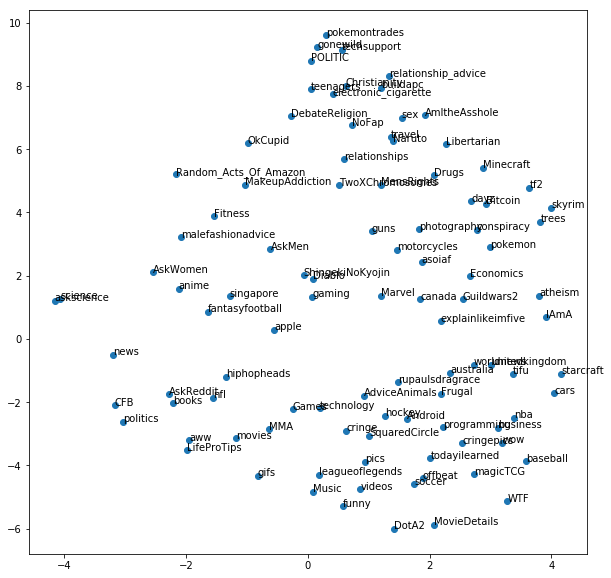

In [32]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

Looking across this plot, we can spot a few interpretable-looking groupings:

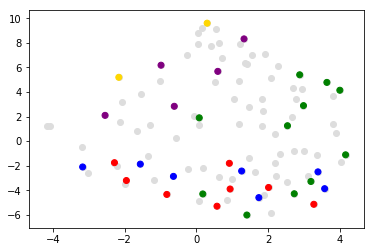

In [33]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()

For instance, video games (e.g., tf2, DotA2; red) tend to group together, along with buy-sell subreddits (e.g., tf2trade, Dota2Trade, yellow), subreddits related to relationships (e.g., AskWomen, relationship_advice; green) and large default-subreddit hubs for sharing random links (e.g., pics, AskReddit; purple).

There may be other interesting groupings that you may spot as well -- for instance, a vaguely right-wing MensRights cluster (with Libertarian, guns); a rather intriguing cluster consisting of politics, sex, business, etc.

Some topical groups are more diffuse -- for instance, sports-based subreddits (blue). Perhaps this is a limitation of our representation, or that these subreddits actually foster very different interactional dynamics.

Another way to delve into these groupings is to look at nearest neighbors of subreddits, in terms of the embedding:

In [34]:
dists = pairwise_distances(subreddit_df.values, metric='cosine')
flat_dists = np.ravel(dists)
idx1, idx2 = np.unravel_index(np.arange(len(flat_dists)), dists.shape)
pairwise_dist_df = pd.DataFrame.from_dict({'p1': subreddit_df.index[idx1],
                                           'p2': subreddit_df.index[idx2],
                                           'dist': flat_dists},
                                           orient='columns')

In [35]:
def print_nearest_neighbors(pairwise_dist_df, 
                           test_subreddits=[],
                           top_N=10):
    for subreddit in test_subreddits:
        subset_df = pairwise_dist_df[(pairwise_dist_df.p1 == subreddit)
                                 & (pairwise_dist_df.p2 != subreddit)]
        print(subreddit)
        print(subset_df.sort_values('dist')[['p2', 'dist']].head(top_N))
        print()

In [36]:
print_nearest_neighbors(pairwise_dist_df, ['apple', 'politics', 'leagueoflegends',
                                          'AskWomen', 'Music', 'pics',
                                          'australia', 'Random_Acts_Of_Amazon',
                                          'Bitcoin', 'MensRights'])

apple
                    p2      dist
3816             Games  0.011274
3858            gaming  0.011301
3810            Diablo  0.013383
3833  ShingekiNoKyojin  0.014511
3856   fantasyfootball  0.017115
3888        technology  0.019940
3871               nfl  0.020418
3848            canada  0.021585
3863            hockey  0.022282
3800     AdviceAnimals  0.022388

politics
               p2      dist
7707          CFB  0.022381
7745        books  0.026223
7743          aww  0.037024
7762  hiphopheads  0.043586
7704    AskReddit  0.045851
7759         gifs  0.047281
7768       movies  0.048274
7771          nfl  0.053557
7721          MMA  0.055961
7720  LifeProTips  0.057664

leagueoflegends
                   p2      dist
6427            Music  0.005480
6497           videos  0.009201
6474             pics  0.010798
6416            Games  0.017502
6468           movies  0.018260
6481  rupaulsdragrace  0.019261
6434    SquaredCircle  0.020220
6493    todayilearned  0.020690
6472    

We can also try to interpret each dimension of the embedding -- roughly speaking the threads, features and subreddits with extremal values along one dimension could be seen as characterizing a particular "type" of discussion, in terms of the discussion structure.

In [37]:
from IPython.display import display

In [38]:
def display_dimension(dim, ascending=True, n=5):
    top_threads = U_df.sort_values(dim, ascending=ascending).head(n)
    display(top_threads)
    display(V_df.sort_values(dim, ascending=ascending).head(n))
    display(subreddit_df.sort_values(dim, ascending=ascending).head(n))
    return top_threads.index

For instance, the first latent dimension divides the space of Reddit discussions between focused dialogues involving 2 people who repeatedly interact, and "expansionary" threads involving multiple people who generally only engage once (as with the corresponding dimension discussed in the paper, this echoes the contrast explored in papers such as Backstrom et. al, 2013). At the subreddit level, we see a divide between subreddits that are selling things (perhaps the dialogues consist of a buyer and a seller) and large default link-sharing subreddits like AskReddit and pics.

In [39]:
top_threads = display_dimension(0, n=10)

,0,1,2,3,4,5,6,subreddit
e5k62bm,-0.685541,0.469148,0.195467,-0.018679,-0.163945,0.493657,0.028323,gifs
e6fk4d2,-0.681639,0.461188,0.224843,0.105933,-0.142822,0.468038,0.146425,Games
e5ekbjt,-0.679752,0.188435,-0.042384,0.291080,-0.124941,0.611301,0.163117,science
e6bj8nr,-0.679206,0.464177,0.215748,0.190665,-0.147664,0.459386,0.086476,technology
e5pvxma,-0.676604,0.465562,0.195420,0.210650,-0.187593,0.452266,0.056216,Games
e6ufgqw,-0.672083,0.266392,0.011116,-0.057482,-0.085893,0.682787,-0.018307,starcraft
e6a3zsv,-0.670457,0.483750,0.206706,0.007082,-0.177416,0.492000,-0.012459,Fitness
e5fvj1n,-0.670302,0.469705,0.207375,0.045382,-0.241660,0.476033,-0.001433,offbeat
e6akj8g,-0.670181,0.230205,-0.025319,0.162968,-0.110259,0.630372,0.247261,Marvel
e665srw,-0.669498,0.458753,0.196184,0.168275,-0.192199,0.452386,0.181439,Drugs


,0,1,2,3,4,5,6
entropy[outdegree over C->C responses],-0.837485,-0.311336,-0.084423,0.298291,0.090838,-8.850111e-16,0.311982
entropy[outdegree over C->c responses],-0.837457,-0.311308,-0.084443,0.298357,0.090861,6.637561e-16,0.312011
is-present[incoming triads],-0.684908,-0.528550,-0.348754,-0.333282,0.117654,-3.366783e-16,-0.070617
max[indegree over c->c responses],-0.592384,0.662204,0.004033,-0.195809,-0.269477,-1.541226e-15,0.315582
norm.max[indegree over c->c responses],-0.592384,0.662204,0.004033,-0.195809,-0.269477,-1.310042e-15,0.315582
max[indegree over C->c responses],-0.592384,0.662204,0.004033,-0.195809,-0.269477,-1.541226e-15,0.315582
norm.max[indegree over C->c responses],-0.592384,0.662204,0.004033,-0.195809,-0.269477,-1.387104e-15,0.315582
count[incoming triads],-0.541080,0.584971,0.024197,-0.588522,-0.133104,-3.181787e-15,-0.019518
mean-nonzero[outdegree over c->c responses],-0.482806,-0.167588,0.371247,-0.024826,0.551257,3.561579e-02,0.543341
is-present[external reciprocity motif],-0.466898,-0.809740,0.048323,0.159239,-0.254408,-2.196330e-15,0.184151


,0,1,2,3,4,5,6
subreddit,,,,,,,
politics,-0.459037,0.171448,-0.027858,0.115797,-0.078420,0.857505,-0.065126
gifs,-0.404412,-0.056660,-0.038212,0.181254,0.004086,0.888159,0.100421
CFB,-0.387781,0.091459,-0.004129,-0.027376,-0.147554,0.893365,-0.143603
LifeProTips,-0.379301,-0.128324,0.088431,0.118748,-0.127227,0.888191,-0.112574
Music,-0.378731,-0.166326,-0.052454,0.147414,-0.023649,0.880341,0.169871
MovieDetails,-0.368004,-0.276575,0.140375,0.278256,0.003645,0.815280,0.162026
aww,-0.366351,-0.018316,0.075890,0.065232,-0.090622,0.919341,0.045123
WTF,-0.360713,-0.288329,0.158831,0.167406,0.128834,0.846537,0.016684
videos,-0.359883,-0.234184,-0.056693,0.215160,-0.040986,0.869438,0.092363
